# Image Classification using CNN

In our previous training dataset, all images are centered. If the images in the test set are off-center, then the MLP approach fails miserably. We want the network to be Translation-Invariant.

<img src="failure-mlp-mnist.jpg" />

Another major problem with a fully connected classifier is that the number of parameters increases very fast since each node in layer L is connected to a node in layer L-1. So it is not feasible to design very deep networks using an MLP structure alone.

## Convolutional Neural Network

Convolutional Neural Networks are a form of Feedforward Neural Networks. Given below is a schema of a typical CNN. The first part consists of Convolutional and max-pooling layers which act as the feature extractor. The second part consists of the fully connected layer which performs non-linear transformations of the extracted features and acts as the classifier.

<img src="cnn-schema1.jpg" />

The convolutional layer can be thought of as the eyes of the CNN. The neurons in this layer look for specific features. If they find the features they are looking for, they produce a high activation.

Convolution can be thought of as a weighted sum between two signals ( in terms of signal processing jargon ) or functions ( in terms of mathematics ). In image processing, to calculate convolution at a particular location (x, y), we extract k x k sized chunk from the image centered at location (x,y). We then multiply the values in this chunk element-by-element with the convolution filter (also sized k x k) and then add them all to obtain a single output. That’s it! Note that k is termed as the kernel size.

An example of convolution operation on a matrix of size 5×5 with a kernel of size 3×3 is shown below :

<img src='convolution-example-matrix.gif'>

The convolution kernel is slid over the entire matrix to obtain an activation map.

Let’s look at a concrete example and understand the terms. Suppose, the input image is of size 32x32x3. This is nothing but a 3D array of depth 3. Any convolution filter we define at this layer must have a depth equal to the depth of the input. So we can choose convolution filters of depth 3 ( e.g. 3x3x3 or 5x5x3 or 7x7x3 etc.). Let’s pick a convolution filter of size 3x3x3. So, referring to the above example, here the convolutional kernel will be a cube instead of a square.

<img src='convolution-demo-diagram.jpg'>

If we can perform the convolution operation by sliding the 3x3x3 filter over the entire 32x32x3 sized image, we will obtain an output image of size 30x30x1. This is because the convolution operation is not defined for a strip 2 pixels wide around the image. We have to ensure the filter is always inside the image. So 1 pixel is stripped away from left, right, top and bottom of the image.

### Activation function

For a 32x32x3 input image and filter size of 3x3x3, we have 30x30x1 locations and there is a neuron corresponding to each location. Then 30x30x1 outputs or activations of all neurons are called the activation maps. The activation map of one layer serves as the input to the next layer.

### Shared weights and biases

In our example, there are 30×30 = 900 neurons because there are that many locations where the 3x3x3 filter can be applied. Unlike traditional neural nets where weights and biases of neurons are independent of each other, in case of CNNs the neurons corresponding to one filter in a layer share the same weights and biases.

### Stride

In the above case, we slid the window by 1 pixel at a time. We can also slide the window by more than 1 pixel. This number is called the stride.

### Multiple Filters

Typically, we use more than 1 filter in one convolution layer. If we use 32 filters we will have an activation map of size 30x30x32. Please refer to Figure below for a graphical view.
Note that all neurons associated with the same filter share the same weights and biases. So the number of weights while using 32 filters is simply 3x3x3x32 = 288 and the number of biases is 32.

The 32 Activation maps obtained from applying the convoltional Kernels is shown below.

<img src='activation-maps-32-kernel.jpg'>

### Max Pooling Layer
Pooling layer is mostly used immediately after the convolutional layer to reduce the spatial size (only width and height, not depth). This reduces the number of parameters, hence computation is reduced. Using fewer parameters avoids overfitting.

Note: Overfitting is the condition when a trained model works very well on training data, but does not work very well on test data.

The most common form of pooling is Max pooling where we take a filter of size  p and apply the maximum operation over the sized part of the image.

<img src='max-pooling-demo.jpg'>

### The Dataset – CIFAR10
The CIFAR10 dataset comes bundled with Keras. It has 50,000 training images and 10,000 test images. There are 10 classes like airplanes, automobiles, birds, cats, deer, dog, frog, horse, ship and truck. The images are of size 32×32. Given below are a few examples.

<img src='cifar10-display-images.png'>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import the Data
The CIFAR10 dataset comes bundled with Keras. We will use the load_data function to load it into memory

In [2]:
from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## Explore the Data
Check out the number of images in training and test data and also the number of classes and some sample images

In [3]:
from keras.utils import to_categorical

Training data shape :  (50000, 32, 32, 3) (50000, 1)
Testing data shape :  (10000, 32, 32, 3) (10000, 1)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


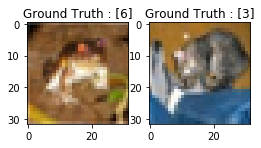

In [4]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[4,2])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))


## Preprocess the Data
Perform normalization of data and convert the labels to categorical variables to be used in Keras

In [5]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [6]:
# Display the change for category label using one-hot encoding
print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

Original label 0 :  [6]
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Define the Model
Create the model with conv layer, max pooling layer, dropout layer and Dense layer

In [7]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

## Train the models 
### Skip this code, if you don't want to train and later load model from the file

In [8]:
model1 = createModel()
batch_size = 256
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

history = model1.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_data, test_labels_one_hot))
model1.evaluate(test_data, test_labels_one_hot)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

Epoch 42/50
50000/50000 [==============================] - 20s 405us/step - loss: 0.4972 - acc: 0.8289 - val_loss: 0.6261 - val_acc: 0.7986
Epoch 43/50
50000/50000 [==============================] - 20s 405us/step - loss: 0.4937 - acc: 0.8296 - val_loss: 0.6702 - val_acc: 0.7932
Epoch 44/50
50000/50000 [==============================] - 20s 404us/step - loss: 0.4969 - acc: 0.8287 - val_loss: 0.6076 - val_acc: 0.8067
Epoch 45/50
50000/50000 [==============================] - 20s 405us/step - loss: 0.4835 - acc: 0.8347 - val_loss: 0.6393 - val_acc: 0.7963
Epoch 46/50
50000/50000 [==============================] - 20s 406us/step - loss: 0.4851 - acc: 0.8328 - val_loss: 0.6487 - val_acc: 0.8059
Epoch 47/50
50000/50000 [==============================] - 23s 456us/step - loss: 0.4816 - acc: 0.8344 - val_loss: 0.7646 - val_acc: 0.7713
Epoch 48/50
50000/50000 [==============================] - 21s 423us/step - loss: 0.4794 - acc: 0.8350 - val_loss: 0.5898 - val_acc: 0.8100
Epoch 49/50
50000/50

[0.6681254535675049, 0.7968]

In [9]:
# Code to save model to disk
from keras.models import model_from_json

# serialize model to JSON
model1_json = model1.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model1_json)
# serialize weights to HDF5
model1.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# code to save history to disk
import pickle
pickle.dump( history.history, open( "history.p", "wb" ) )
print('saved history')

saved history


## Check the loss and accuracy curves

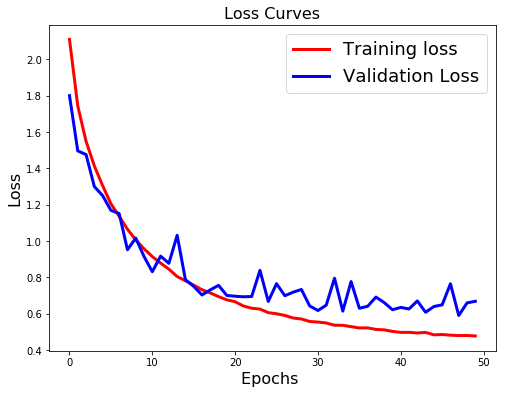

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

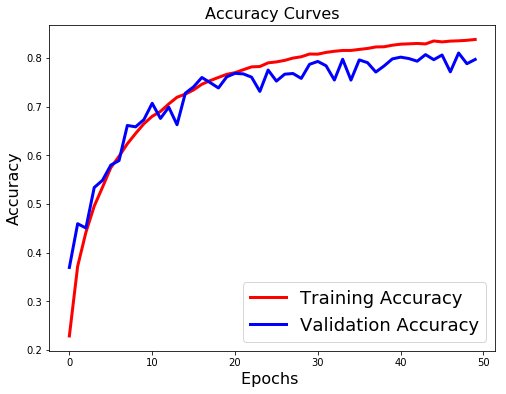

In [11]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [16]:
del model1

# Run onwards, if you want to load model from file

In [8]:
# load json and create model
from keras.models import model_from_json
json_file = open('model1.json', 'r')
loaded_model1_json = json_file.read()
json_file.close()
model1 = model_from_json(loaded_model1_json)
# load weights into new model
model1.load_weights("model1.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


In [25]:
del history.history

### Loading history from file

Showing results by loading history from file

In [11]:
# load history from file
import pickle
history = pickle.load( open( "history.p", "rb" ) )
print('history loaded')

history loaded


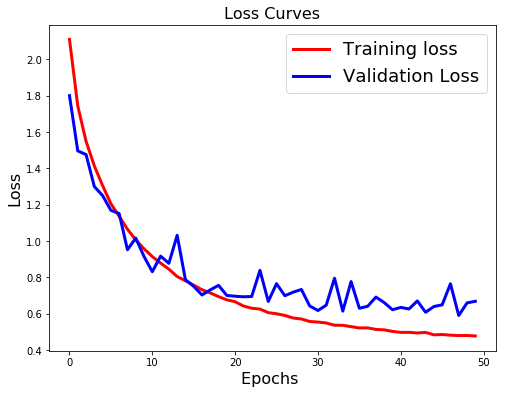

In [12]:
plt.figure(figsize=[8,6])
plt.plot(history['loss'],'r',linewidth=3.0)
plt.plot(history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

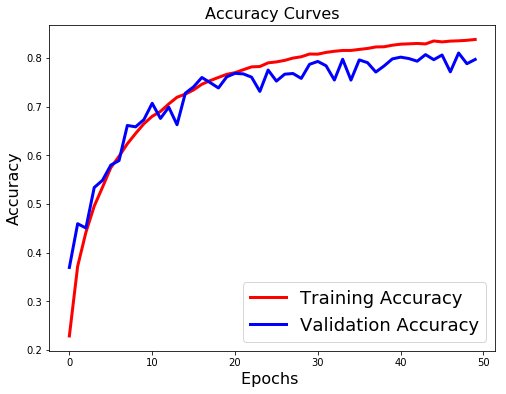

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history['acc'],'r',linewidth=3.0)
plt.plot(history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Train using Data Augmentation
### Skip this code, if you don't want to train and later load model from the file
Here we use the ImageDataGenerator class in Keras to perform Data Augmentation. We perform horizontal and vertical shift of the image and also flipping the image randomly.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

model2 = createModel()

model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 50
datagen = ImageDataGenerator(
#         zoom_range=0.2, # randomly zoom into images
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# datagen.fit(train_data)

# Fit the model on the batches generated by datagen.flow().
history2 = model2.fit_generator(datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
                              epochs=epochs,
                              validation_data=(test_data, test_labels_one_hot),
                              workers=4)

model2.evaluate(test_data, test_labels_one_hot)

Epoch 1/50
196/196 [==============================] - 21s 108ms/step - loss: 2.0988 - acc: 0.2234 - val_loss: 1.7701 - val_acc: 0.3800
Epoch 2/50
196/196 [==============================] - 21s 106ms/step - loss: 1.7777 - acc: 0.3518 - val_loss: 1.5425 - val_acc: 0.4293
Epoch 3/50
196/196 [==============================] - 21s 107ms/step - loss: 1.5818 - acc: 0.4266 - val_loss: 1.3595 - val_acc: 0.5086
Epoch 4/50
196/196 [==============================] - 21s 108ms/step - loss: 1.4524 - acc: 0.4763 - val_loss: 1.3255 - val_acc: 0.5241
Epoch 5/50
196/196 [==============================] - 20s 103ms/step - loss: 1.3556 - acc: 0.5171 - val_loss: 1.2516 - val_acc: 0.5523
Epoch 6/50
196/196 [==============================] - 20s 104ms/step - loss: 1.2763 - acc: 0.5475 - val_loss: 1.0576 - val_acc: 0.6194
Epoch 7/50
196/196 [==============================] - 20s 104ms/step - loss: 1.2068 - acc: 0.5711 - val_loss: 1.0699 - val_acc: 0.6265
Epoch 8/50
196/196 [==============================] - 2

[0.5162607864379882, 0.8263]

In [13]:
from keras.models import model_from_json

# serialize model to JSON
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)
# serialize weights to HDF5
model2.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
pickle.dump( history2.history, open( "history2.p", "wb" ) )
print('saved history')

saved history


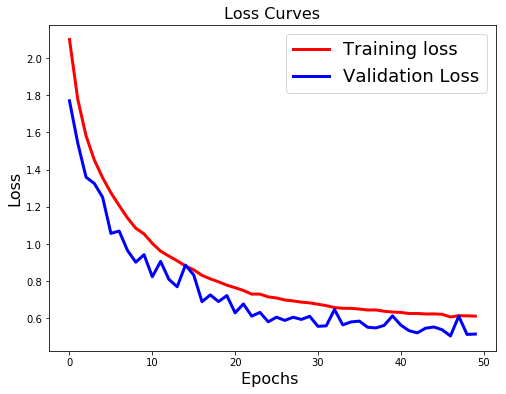

In [14]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

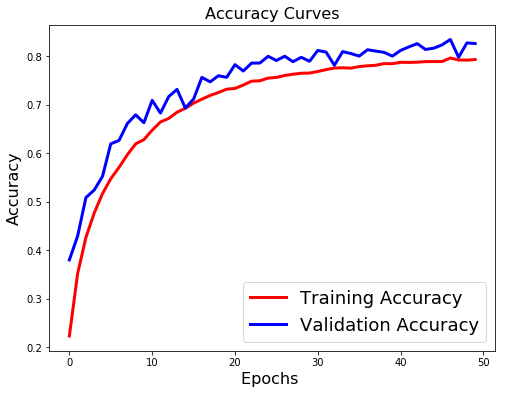

In [15]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Run onwards, if you want to load model from file

In [16]:
# load json and create model
from keras.models import model_from_json
json_file2 = open('model2.json', 'r')
loaded_model2_json = json_file2.read()
json_file2.close()
model2 = model_from_json(loaded_model2_json)
# load weights into new model
model2.load_weights("model2.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


### Loading history from file

Showing results by loading history from file

In [14]:
history2 = pickle.load( open( "history2.p", "rb" ) )
print('history loaded')

history loaded


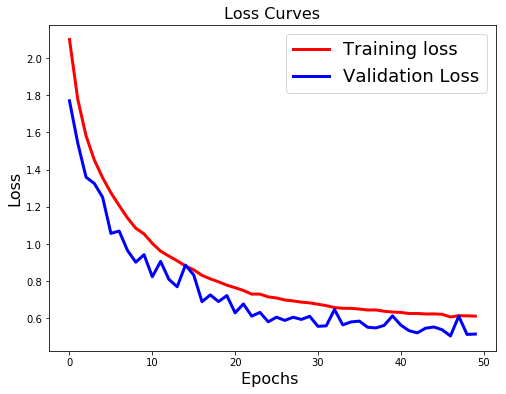

In [15]:
plt.figure(figsize=[8,6])
plt.plot(history2['loss'],'r',linewidth=3.0)
plt.plot(history2['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history2['acc'],'r',linewidth=3.0)
plt.plot(history2['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)